# Clinical Text Interpretability Challenge (NLP Implementation)
## Experiments - Amazon reviews

### Baseline experiment and exploration

In [55]:
# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [56]:
df = pd.read_csv("Amazon review dataset.csv") # read data

### EDA

In [57]:
df.sample(5) # sample to see our data looks like

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
11631,5,"10 16, 2010",u25113642,Malcolm Arnold's two sets of English Dances we...,A really enjoyable recording,1287187200,Classical,$18.99,p15568136,31954807,NaN
7776,5,"10 7, 2004",u78949550,You have to put things into perspective. The S...,Could be the greatest Pop album ever recorded,1097107200,Alternative Rock,$12.41,p88679355,99912335,NaN
21414,5,"12 10, 2014",u24671712,love this cd,Five Stars,1418169600,Alternative Rock,$8.95,p21661260,27298324,NaN
153950,5,"06 16, 2015",u14753272,Just what I wanted.,Five Stars,1434412800,Pop,$4.90,p38756651,19827889,NaN
91593,4,"01 21, 2009",u07628768,large ensembles with vocals are often plagued ...,candidate for best of '08.,1232496000,Jazz,$10.48,p36663392,21965362,NaN


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         200000 non-null  int64 
 1   reviewTime      200000 non-null  object
 2   reviewerID      200000 non-null  object
 3   reviewText      199956 non-null  object
 4   summary         199962 non-null  object
 5   unixReviewTime  200000 non-null  int64 
 6   category        200000 non-null  object
 7   price           200000 non-null  object
 8   itemID          200000 non-null  object
 9   reviewHash      200000 non-null  int64 
 10  image           463 non-null     object
dtypes: int64(3), object(8)
memory usage: 16.8+ MB


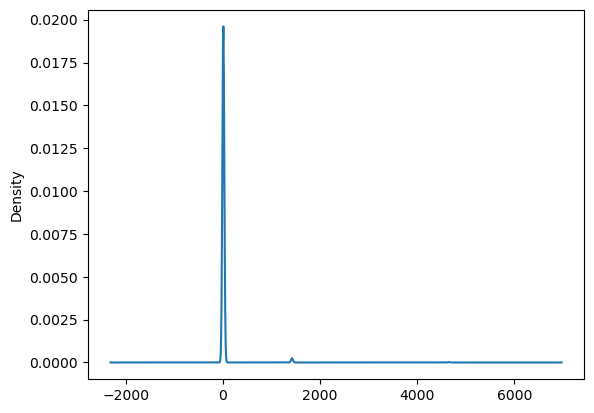

In [59]:
# Distribution: lenght of price column
df["price"].apply(lambda x: len(str.strip(x))).plot(kind="kde");

In [60]:
# Price Variable study
print(f'median Len: {df["price"].apply(lambda x: len(str.strip(x))).median()}')
print(f'Min: {df["price"].apply(lambda x: len(str.strip(x))).min()}', f'Max: {df["price"].apply(lambda x: len(str.strip(x))).max()}')

median Len: 6.0
Min: 5 Max: 4648


In [61]:
# Same items with different prices?
df.groupby("itemID")["price"].nunique()[df.groupby("itemID")["price"].nunique() > 1]

itemID
p32698785    2
p34191333    2
p56249949    2
p66891332    2
Name: price, dtype: int64

In [62]:
# Same items with different categories?
df.groupby("itemID")["category"].nunique()[df.groupby("itemID")["category"].nunique() > 1]

itemID
p56249949    2
p66891332    2
Name: category, dtype: int64

In [63]:
df = df[df["price"].apply(lambda x: len(str.strip(x))) < 10].drop("image",axis=1).dropna()
df["price"] = df.price.str.replace('$', '').astype(float)

# some items have more than one category and price assigned. We want to ensure uniqueness
for item in df.groupby("itemID")["price"].nunique()[df.groupby("itemID")["price"].nunique() > 1].index:
    mean_price = df[df["itemID"] == item]["price"].mean()
    df.loc[df['itemID'] == item, 'price'] = mean_price
for item in df.groupby("itemID")["category"].nunique()[df.groupby("itemID")["category"].nunique() > 1].index:
    mode_category = df[df["itemID"] == item]["category"].mode()[0]
    df.loc[df['itemID'] == item, 'category'] = mode_category

# Pre-process for modeling
class IterableWrapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(lambda x: [x])

preprocessor = ColumnTransformer(
    transformers=[
        ('text1', TfidfVectorizer(stop_words='english'), 'reviewText'),
        ('text2', TfidfVectorizer(stop_words='english'), 'summary'),
        ('price', StandardScaler(), ['price']),
        ('reviewTime', StandardScaler(), ['unixReviewTime']),
        ("category", OneHotEncoder(), ["category"]),
        ('item_hash', make_pipeline(IterableWrapper(), FeatureHasher(n_features=20, input_type='string')), 'itemID'),
        ('reviewer_hash', make_pipeline(IterableWrapper(), FeatureHasher(n_features=20, input_type='string')), 'reviewerID'),
    ])

# Creating a pipeline with the preprocessor and predictor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Prepare the dataset
X = df[['reviewText', 'summary', 'price', 'unixReviewTime', 'category', 'reviewerID', 'itemID']]
y = df['overall']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training the model
model.fit(X_train, y_train)

# Predicting the ratings
y_pred = model.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

MSE: 1.004149073562897


In [64]:
# Including feature engineered variables

preprocessor = ColumnTransformer(
    transformers=[
        ('review', TfidfVectorizer(stop_words='english'), 'reviewText'),
        ('summary', TfidfVectorizer(stop_words='english'), 'summary'),
        ('price', StandardScaler(), ['price']),
        ("userAvgRating", StandardScaler(), ["userAvgRating"]),
        ("userAvgPaidPrice", StandardScaler(), ["userAvgPaidPrice"]),
        ("itemAvgRating", StandardScaler(), ["itemAvgRating"]),
        ('reviewTime', StandardScaler(), ['unixReviewTime']),
        ("dayofweek", OneHotEncoder(), ["reviewDayOfWeek"]),
        ("category", OneHotEncoder(), ["category"]),
        ('item_hash', make_pipeline(IterableWrapper(), FeatureHasher(n_features=20, input_type='string')), 'itemID'),
        ('reviewer_hash', make_pipeline(IterableWrapper(), FeatureHasher(n_features=20, input_type='string')), 'reviewerID'),
    ])

# Creating a pipeline with the preprocessor and a regressor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Splitting the dataset and feature engineering
df['reviewDateTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

df['reviewDayOfWeek'] = df['reviewDateTime'].dt.dayofweek # extract day of week


X = df[['reviewText', 'summary', 'price', 'unixReviewTime', 'category', 'reviewerID', 'itemID',"reviewDayOfWeek","overall"]]
y = df['overall']

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
user_avg_rating_train = X_train.groupby('reviewerID')['overall'].mean()
user_avg_paidprice_train = X_train.groupby('reviewerID')['price'].mean()
item_avg_rating_train = X_train.groupby('itemID')['overall'].mean()

global_avg_rating = X_train['overall'].mean()
global_avg_paidprice = X_train['price'].mean()

X_train['userAvgRating'] = X_train['reviewerID'].map(user_avg_rating_train)
X_test['userAvgRating'] = X_test['reviewerID'].map(user_avg_rating_train).fillna(global_avg_rating)

X_train['userAvgPaidPrice'] = X_train['reviewerID'].map(user_avg_paidprice_train)
X_test['userAvgPaidPrice'] = X_test['reviewerID'].map(user_avg_paidprice_train).fillna(global_avg_paidprice)

X_train['itemAvgRating'] = X_train['itemID'].map(item_avg_rating_train)
X_test['itemAvgRating'] = X_test['itemID'].map(item_avg_rating_train).fillna(global_avg_rating)
# Training the model
model.fit(X_train, y_train)

# Test MSE
y_pred = model.predict(X_test)
f"Test MSE: {mean_squared_error(y_test, y_pred)}"

'Test MSE: 0.9845879108702847'

### More robust approach (Neural Network)

For this exercise, I simulated a **neural collaborative filtering** architecture. To handle our text features (`reviewText` and `summary`), we used Google's Universal Sentence Encoder (USE). USE encodes text into high-dimensinal vectors. Originally, it was trained on natural language prediction tasks, deffering from other word-level embedding models ([paper](https://research.google/pubs/universal-sentence-encoder/)).

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization
from tensorflow.keras import layers, Model
import tensorflow_hub as hub

df = pd.read_csv("/kaggle/input/amazonmusicreviews/Amazon review dataset.csv")
df = df[df["price"].apply(lambda x: len(str.strip(x))) < 10].drop("image",axis=1).dropna()
df["price"] = df.price.str.replace('$', '').astype(float)

# some items have more than one category and price assigned. We want to ensure uniqueness
for item in df.groupby("itemID")["price"].nunique()[df.groupby("itemID")["price"].nunique() > 1].index:
    mean_price = df[df["itemID"] == item]["price"].mean()
    df.loc[df['itemID'] == item, 'price'] = mean_price
for item in df.groupby("itemID")["category"].nunique()[df.groupby("itemID")["category"].nunique() > 1].index:
    mode_category = df[df["itemID"] == item]["category"].mode()[0]
    df.loc[df['itemID'] == item, 'category'] = mode_category

df['reviewerID'] = df['reviewerID'].astype('category').cat.codes
df['itemID'] = df['itemID'].astype('category').cat.codes
df['category'] = df['category'].astype('category').cat.codes

# Split the data and feature engineering
X = df[['reviewerID', 'itemID', 'category', 'price', 'unixReviewTime', 'reviewText', "summary", "overall"]]
y = df['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

user_avg_rating_train = X_train.groupby('reviewerID')['overall'].mean()
user_avg_paidprice_train = X_train.groupby('reviewerID')['price'].mean()
item_avg_rating_train = X_train.groupby('itemID')['overall'].mean()

global_avg_rating = X_train['overall'].mean()
global_avg_paidprice = X_train['price'].mean()

X_train['userAvgRating'] = X_train['reviewerID'].map(user_avg_rating_train)
X_test['userAvgRating'] = X_test['reviewerID'].map(user_avg_rating_train).fillna(global_avg_rating)

X_train['userAvgPaidPrice'] = X_train['reviewerID'].map(user_avg_paidprice_train)
X_test['userAvgPaidPrice'] = X_test['reviewerID'].map(user_avg_paidprice_train).fillna(global_avg_paidprice)

X_train['itemAvgRating'] = X_train['itemID'].map(item_avg_rating_train)
X_test['itemAvgRating'] = X_test['itemID'].map(item_avg_rating_train).fillna(global_avg_rating)

price_mean = global_avg_paidprice
price_std = X_train['price'].std()

unix_review_time_mean = X_train['unixReviewTime'].mean()
unix_review_time_std = X_train['unixReviewTime'].std()

userAvgRating_mean = X_train['userAvgRating'].mean()
userAvgRating_std = X_train['userAvgRating'].std()

itemAvgRating_mean = X_train['itemAvgRating'].mean()
itemAvgRating_std = X_train['itemAvgRating'].std()

# NN Architecture
reviewer_id_input = layers.Input(shape=(1,), name='reviewer_id', dtype=tf.int32)
item_id_input = layers.Input(shape=(1,), name='item_id', dtype=tf.int32)
category_input = layers.Input(shape=(1,), name='category', dtype=tf.int32)
price_input = layers.Input(shape=(1,), name='price')
paidprice_input = layers.Input(shape=(1,), name='paid_price', dtype=tf.int32)
unix_review_time_input = layers.Input(shape=(1,), name='unixReviewTime')
userAvgRating_input = layers.Input(shape=(1,), name='userAvgRating')
itemAvgRating_input = layers.Input(shape=(1,), name='itemAvgRating')
review_text_input = layers.Input(shape=(), dtype=tf.string, name='review_text')
summary_input = layers.Input(shape=(), dtype=tf.string, name='summary')


# Norm layers
## Init
price_normalizer = Normalization(mean=price_mean, variance=np.square(price_std), axis=None)
paidprice_normalizer = Normalization(mean=price_mean, variance=np.square(price_std), axis=None)
unix_review_time_normalizer = Normalization(mean=unix_review_time_mean, variance=np.square(unix_review_time_std), axis=None)
userAvgRating_normalizer = Normalization(mean=userAvgRating_mean, variance=np.square(userAvgRating_std), axis=None)
itemAvgRating_normalizer = Normalization(mean=itemAvgRating_mean, variance=np.square(itemAvgRating_std), axis=None)
## Prep
price_normalized = price_normalizer(price_input)
paidprice_normalized = paidprice_normalizer(paidprice_input)
unix_review_time_normalized = unix_review_time_normalizer(unix_review_time_input)
userAvgRating_normalized = userAvgRating_normalizer(userAvgRating_input)
itemAvgRating_normalized = itemAvgRating_normalizer(itemAvgRating_input)

# Universal Sentence Encoder for both summary and review text
use_layer1 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)
use_layer2 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

review_text_vect = use_layer1(review_text_input)
summary_vect = use_layer2(summary_input)

# Embeddings simulating Collaborative Filtering
reviewer_embedding = layers.Embedding(input_dim=X_train['reviewerID'].nunique(), output_dim=16)(reviewer_id_input)
item_embedding = layers.Embedding(input_dim=X_train['itemID'].nunique(), output_dim=16)(item_id_input)
category_embedding = layers.Embedding(input_dim=X_train['category'].nunique(), output_dim=4)(category_input)

# Combine inputs
concatenated = layers.concatenate([
    layers.Flatten()(reviewer_embedding),
    layers.Flatten()(item_embedding),
    layers.Flatten()(category_embedding),
    price_normalized,
    paidprice_normalized,
    userAvgRating_normalized,
    itemAvgRating_normalized,
    unix_review_time_normalized,
    review_text_vect,
    summary_vect
])

# Linear layers
dense_layer = layers.Dense(256, activation='relu')(concatenated)
dense_layer = layers.Dropout(0.5)(dense_layer)
output = layers.Dense(1, activation='relu')(dense_layer)  # ReLU as our outputs are positive numbers

# Compile the model
model = Model(inputs=[reviewer_id_input, item_id_input, 
                      category_input, price_input, paidprice_input, userAvgRating_input, itemAvgRating_input, unix_review_time_input,
                     review_text_input, summary_input,],
              outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss='mse')

model.summary()

2024-02-19 21:01:03.159614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:01:03.159708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:01:03.288046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 reviewer_id (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 item_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 category (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 16)                1033968   ['reviewer_id[0][0]']         
                                                                                              

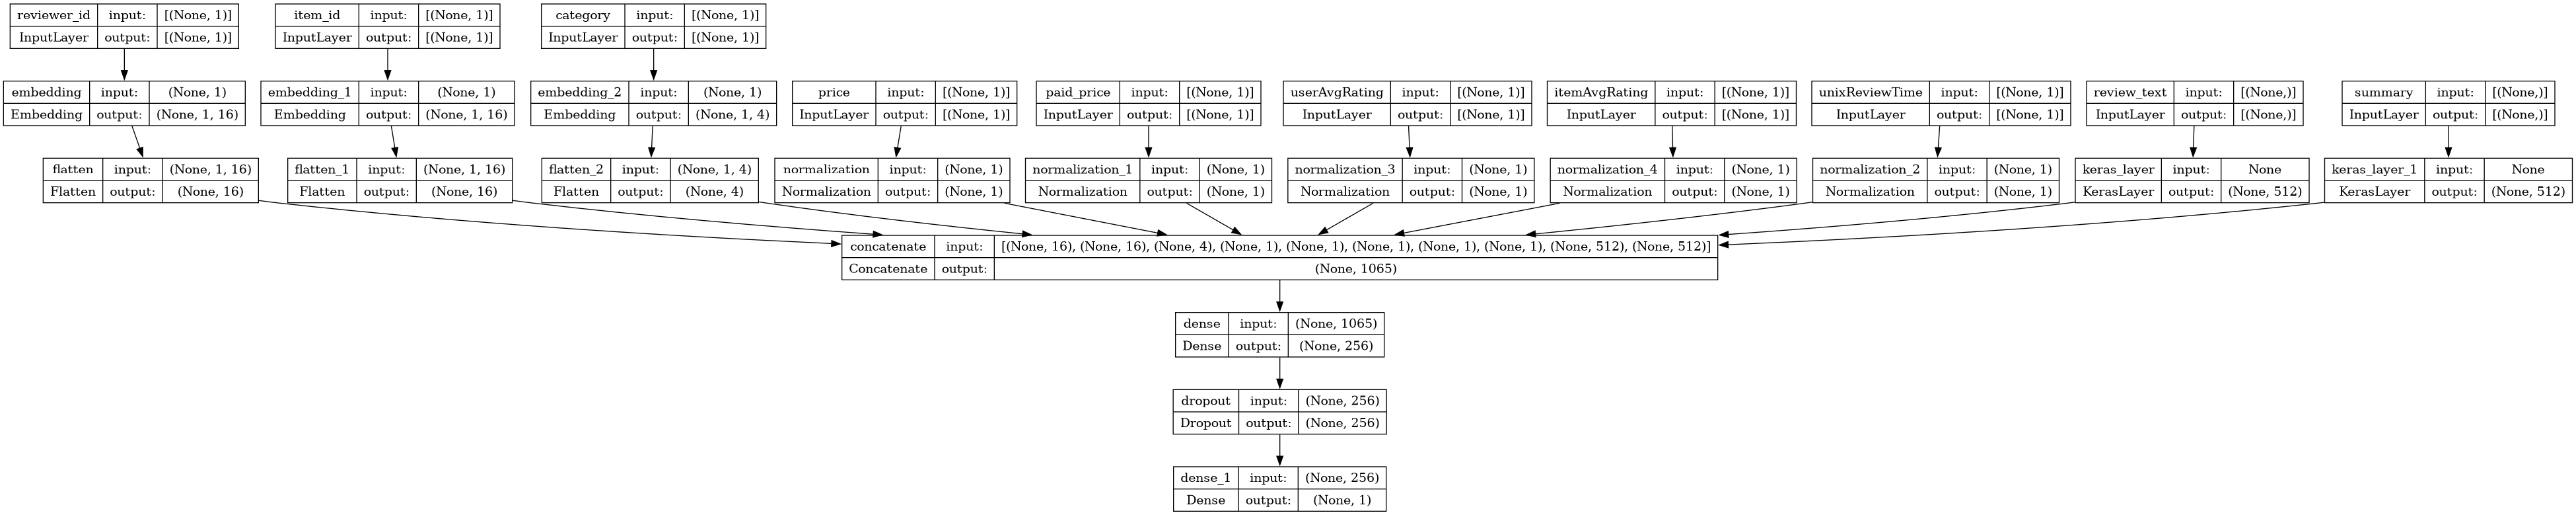

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='amazon_reviews_architecture.png')

In [ ]:
# NN callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model', save_best_only=True, 
                                                               monitor='val_loss', mode='min', save_format='tf', save_weights_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10,patience=3, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss")

# dataset prep
train_inputs = {
    'reviewer_id': X_train['reviewerID'].values.astype(np.int32),  
    'item_id': X_train['itemID'].values.astype(np.int32),
    'category': X_train['category'].values.astype(np.int32),
    'price': X_train['price'].values.astype(np.float32),  
    'paid_price': X_train['userAvgPaidPrice'].values.astype(np.float32),  
    'unixReviewTime': X_train['unixReviewTime'].values.astype(np.float32),
    "userAvgRating": X_train['userAvgRating'].to_numpy(),
    "itemAvgRating": X_train['itemAvgRating'].to_numpy(),
    'review_text': X_train['reviewText'].to_numpy(),
    'summary': X_train['summary'].to_numpy(),
}

test_inputs = {
    'reviewer_id': X_test['reviewerID'].values.astype(np.int32),
    'item_id': X_test['itemID'].values.astype(np.int32),
    'category': X_test['category'].values.astype(np.int32),
    'price': X_test['price'].values.astype(np.float32), 
    'paid_price': X_test['userAvgPaidPrice'].values.astype(np.float32),  
    'unixReviewTime': X_test['unixReviewTime'].values.astype(np.float32),  
    "userAvgRating": X_test['userAvgRating'].to_numpy(),
    "itemAvgRating": X_test['itemAvgRating'].to_numpy(),
    'review_text': X_test['reviewText'].to_numpy(),  
    'summary': X_test['summary'].to_numpy()
}

# model training
history = model.fit(train_inputs, y_train.values, epochs=20, 
                    validation_data=(test_inputs, y_test.values), 
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/20


I0000 00:00:1708376536.317089      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4930/4930 [==============================] - 213s 41ms/step - loss: 0.5167 - val_loss: 0.6025 - lr: 0.0010
Epoch 2/20
4930/4930 [==============================] - 196s 40ms/step - loss: 0.3373 - val_loss: 0.6024 - lr: 0.0010
Epoch 3/20
4930/4930 [==============================] - 183s 37ms/step - loss: 0.2724 - val_loss: 0.6084 - lr: 0.0010
Epoch 4/20
4930/4930 [==============================] - 198s 40ms/step - loss: 0.2279 - val_loss: 0.5912 - lr: 0.0010
Epoch 5/20
4930/4930 [==============================] - 182s 37ms/step - loss: 0.2006 - val_loss: 0.6059 - lr: 0.0010
Epoch 6/20
4930/4930 [==============================] - 183s 37ms/step - loss: 0.1817 - val_loss: 0.6043 - lr: 0.0010
Epoch 7/20
4929/4930 [============================>.] - ETA: 0s - loss: 0.1690
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4930/4930 [==============================] - 182s 37ms/step - loss: 0.1690 - val_loss: 0.5991 - lr: 0.0010
Epoch 8/20
4930/4930 [==================

In [ ]:
model_path = "best_model"
model2 = tf.keras.models.load_model(model_path)
model2.evaluate(test_inputs, y_test.values)

1233/1233 [==============================] - 35s 28ms/step - loss: 0.5912


0.5911562442779541

## Appendix

Preparing objects for web app

In [ ]:
# creating lookup tables for app
import json
item_db = X_train.groupby('itemID').agg({'category': 'first',  'price': 'mean', 'itemAvgRating': 'mean'}).to_dict('index')
with open("item_db.json", 'w') as json_f:
    json.dump(item_db, json_f,indent=4)
user_db = X_train.groupby('reviewerID').agg({'userAvgRating': 'mean', "userAvgPaidPrice": 'mean', "unixReviewTime": 'mean'}).to_dict('index')
with open("user_db.json", 'w') as json_f:
    json.dump(user_db, json_f,indent=4)

In [ ]:
import json
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

with open("user_db.json",'r') as f:
    user_db = json.load(f)
with open("item_db.json",'r') as f:
    item_db = json.load(f)

model_path = "/kaggle/working/best_model"
# with tf.keras.utils.custom_object_scope({'KerasLayer': hub.KerasLayer}):
model = tf.keras.models.load_model(model_path)
# model.evaluate(test_inputs, y_test.values)

In [ ]:
import numpy as np
def predict_rating(reviewerID, itemID):
    # Fetch fixed attributes from lookup tables
    item_attributes = item_db.get(itemID, {})
    user_attributes = user_db.get(reviewerID, {})

    # Handle missing attributes, possibly with global averages or predefined neutral values
    category = item_attributes.get('category', 4) #mode
    price = item_attributes.get('price', 13.71) #mean
    avg_paid_price = user_db.get('userAvgPaidPrice', 13.71) #mean
    itemAvgRating = item_attributes.get('itemAvgRating', 4)# mean
    userAvgRating = user_attributes.get('userAvgRating', 4)# mean
    review_time = user_attributes.get('unixReviewTime', 1285579290) # mean

    # Assuming use of neutral placeholders for text inputs
    reviewText_placeholder = ""
    summary_placeholder = ""
    
    # Construct the input dictionary for prediction
    prediction_inputs = {
        'reviewer_id': np.array([reviewerID], dtype=np.int32),
        'item_id': np.array([itemID], dtype=np.int32),
        'category': np.array([category], dtype=np.int32),
        'price': np.array([price], dtype=np.float32),
        'paid_price': np.array([price], dtype=np.float32),  # Assuming you want to reuse price here
        "unixReviewTime": np.array([review_time], dtype=np.float32),  
        'userAvgRating': np.array([userAvgRating], dtype=np.float32),
        'itemAvgRating': np.array([itemAvgRating], dtype=np.float32),
        'review_text': np.array([reviewText_placeholder]),
        'summary': np.array([summary_placeholder]),
    }
    
    # Load and predict with your model
    prediction = model.predict(prediction_inputs)
    
    return prediction.item()

# Giving only a (user, item) pair
predict_rating("61658", "5000")

1/1 [==============================] - 0s 36ms/step


4.568261623382568